<a href="https://colab.research.google.com/github/Rishiande/sample/blob/main/Tavva1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview These sections match the marking scheme. Each heading indicates the marks for each and type of content that should be included (either Markdown or Code). You can prepare markdown sections in Microsoft Word, but remember to change the cell type to 'Markdown' so the cell is not executed as code. (See: Markdown)

Rename the Notebook replacing the words '_KF7032Template' with your user id (something like w12345678_KF7032) Before you submit the final version of your notebook, you should delete all output, and then run all cells. This checks that your program is consistent. Finally download the notebooks as an .ipynb file for assessment, and also as an html file that will readable by examiners who do not have Jupyter. Sections identified as Markdown should be at least one paragraph of text. The total word limit for markdown is 2500 words

1.   Introduction: The Crime Analysis task ...Markdown, 10 Marks, Max 300 Words
Drugs impair cognitive abilities while simultaneously inducing feelings of heightened excitement and aggression. This affects logical thinking and decision-making, which can lead to poor judgment and violent behavior. Numerous homicide cases have been linked to alcohol or drug intoxication as primary factors, suggesting a connection between drug use and gun violence [1]. Miron et al. [2] conducted a regression analysis between gun control laws and drug abuse, concluding that restrictive gun laws can actually increase violence. Their findings also indicated that higher drug possession arrest rates are positively correlated with higher homicide rates. Fajnzylber et al. [3] analyzed crime statistics, focusing on homicide rates from 1970 to 1994. Their study incorporated various factors such as GDP per capita, education levels, urbanization, defense measures, and religious composition. Rasmussen et al. [4] found that higher drug arrest rates correlate with increased violent crime rates. They also observed that higher drug enforcement in one area can disrupt the equilibrium in neighboring regions, leading to higher crime rates there.

The current study aims to examine violent crimes in the United Kingdom (UK) over the period from 2010 to 2020. The goal is to investigate the possible causes of violent crime in the UK. As suggested by the literature, drug abuse and violent crimes are often interconnected. This study analyzes published crime data from the UK police to explore various aspects of violent crime. Visualization techniques are employed to examine crime trends over the past decade, with the aid of modern cloud computing methods to handle large datasets

In [5]:
!pip install pmdarima
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql.functions import count, col, isnull, isnan, when
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import plotly.express as px
import pandas as pd
import requests
import seaborn as sns

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
requests.packages.urllib3.disable_warnings()
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

%matplotlib inline

In [6]:
!pip install pmdarima

In [7]:
spark = SparkSession.builder.appName('DataFrame').enableHiveSupport().getOrCreate()

#format Look like panda output format
spark.conf.set('spark.sql.repl.eagerEval.enabled',True)

In [8]:
# Read the all_crimes21_hdr.txt.gz file
#df = spark.read.csv('Downloads/all_crimes21_hdr.txt.gz', header=True, inferSchema=True)
# Read the LSOA_pop_v2.csv file
#df_dep = spark.read.csv('Downloads/Sample_Data_Only_For_Test.csv', header=True)

# Read the all_crimes21_hdr.txt.gz file
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .csv('/content/drive/MyDrive/all_crimes21_hdr.txt.gz')

# Read the LSOA_pop_v2.csv file
df_dep = spark.read \
    .option("header", "true") \
    .csv('/content/LSOA_pop_v2.csv')

# Read the posttrans.csv file
df_posttrans = spark.read \
    .option("header", "true") \
    .csv('/content/posttrans.csv')

In [9]:
df.show(2)

+--------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------------------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    NULL|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 NULL|   NULL|
|    NULL|2010-12-01 00:00:00|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 NULL|   NULL|
+--------+----------

In [10]:
# Check if 'Liverpool' is present in the 'Location' column more precisely
df.filter(df['Location'].like('%Liverpool%')).show(5)

+--------+-------------------+-------------------+-------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|Crime ID|              Month|        Reported by|       Falls within|Longitude| Latitude|            Location|LSOA code| LSOA name|          Crime type|Last outcome category|Context|
+--------+-------------------+-------------------+-------------------+---------+---------+--------------------+---------+----------+--------------------+---------------------+-------+
|    NULL|2010-12-01 00:00:00|Bedfordshire Police|Bedfordshire Police|-0.421907|51.881303|On or near Liverp...|E01015794|Luton 018F|Anti-social behav...|                 NULL|   NULL|
|    NULL|2010-12-01 00:00:00|Bedfordshire Police|Bedfordshire Police|-0.421907|51.881303|On or near Liverp...|E01015794|Luton 018F|Anti-social behav...|                 NULL|   NULL|
|    NULL|2010-12-01 00:00:00|Bedfordshire Police|Bedfordshire Police|-0.421907|

In [11]:
df_dep.show(2)

+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); measures: Value|
+----+------------

In [12]:
df_posttrans.show(2)

+--------+---------+---------+
|Postcode|      Lon|      Lat|
+--------+---------+---------+
|AB10 1XG|57.144156|-2.114864|
|AB10 6RN|57.137871|-2.121487|
+--------+---------+---------+
only showing top 2 rows



In [13]:
# Convert a reduced or filtered DataFrame to Pandas
pddf_dep = df_dep.limit(1000).toPandas()  # Adjust the limit based on your needs

In [14]:
pddf_dep.head(10)

,date,geography,geography code,Rural Urban,Variable: All usual residents; measures: Value,Variable: Males; measures: Value,Variable: Females; measures: Value,Variable: Lives in a household; measures: Value,Variable: Lives in a communal establishment; measures: Value,Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value,Variable: Area (Hectares); measures: Value,Variable: Density (number of persons per hectare); measures: Value
0,2011,Darlington 001B,E01012334,Total,2466,1220,1246,2466,0,42,6033.58,0.4
1,2011,Darlington 001C,E01012335,Total,1383,682,701,1383,0,21,114.01,12.1
2,2011,Darlington 001D,E01012366,Total,2008,972,1036,2008,0,30,6718.16,0.3
3,2011,Darlington 001E,E01033481,Total,1364,680,684,1350,14,21,146.95,9.3
4,2011,Darlington 001F,E01033482,Total,1621,810,811,1621,0,16,234.31,6.9
5,2011,Darlington 002C,E01012323,Total,1563,799,764,1563,0,12,55.47,28.2
6,2011,Darlington 002D,E01012324,Total,1399,671,728,1399,0,15,20.68,67.6
7,2011,Darlington 002E,E01032545,Total,1259,631,628,1257,2,9,36.06,34.9
8,2011,Darlington 002F,E01032546,Total,1776,886,890,1775,1,15,93.82,18.9
9,2011,Darlington 003A,E01012328,Total,1571,768,803,1571,0,11,25.72,61.1


In [15]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=pddf_dep)

https://docs.google.com/spreadsheets/d/1lXPzHb-aN-R6f1nXYfk82HlJ63GECpmxXFWoZtd1s_0#gid=0


In [16]:
# Filter the DataFrame for Violent Crimes
df_violentCrime = df.filter(df['Crime type'] == 'Violent crime')

# Filter the DataFrame for Drugs-related Crimes
drugAbuse = df.filter(df['Crime type'] == 'Drugs')

In [17]:
# Group by 'Month' and count occurrences for all crimes
crimeRate_all = df.groupBy('Month').count().toPandas()

In [18]:
# Filter the DataFrame for Drugs-related Crimes
df_drugAbuse = df.filter(df['Crime type'] == 'Drugs')

# Group by 'Month' and count occurrences for Violent Crimes
crimeRate_violent = df_violentCrime.groupBy('Month').count().toPandas()

# Group by 'Month' and count occurrences for Drug-related Crimes
crimeRate_drug = df_drugAbuse.groupBy('Month').count().toPandas()

In [19]:
# Create the plot for Overall Crimes
fig_all = px.line(crimeRate_all.sort_values(by='Month'), x='Month', y='count', title='Fig. 1: Overall Crime Number from 2010-21')
fig_all.show()

In [20]:
# Create the plot for Violent Crimes
fig_violent = px.line(crimeRate_violent.sort_values(by='Month'), x='Month', y='count', title='Fig. 2: Violent Crime Number from 2010-21')
fig_violent.show()

In [21]:
# Create the plot for Drug-related Crimes
fig_drug = px.line(crimeRate_drug.sort_values(by='Month'), x='Month', y='count', title='Fig. 3: Drug-related Crime Number from 2010-21')
fig_drug.show()

In [22]:
# Limit the number of rows to 100,000 (or a number that fits into memory)
pdDF = df.limit(100000).toPandas()

# Display the first few rows
print(pdDF.head())

  Crime ID      Month                     Reported by  \
0     None 2010-12-01  Avon and Somerset Constabulary   
1     None 2010-12-01  Avon and Somerset Constabulary   
2     None 2010-12-01  Avon and Somerset Constabulary   
3     None 2010-12-01  Avon and Somerset Constabulary   
4     None 2010-12-01  Avon and Somerset Constabulary   

                     Falls within  Longitude   Latitude  \
0  Avon and Somerset Constabulary  -0.805600  51.819143   
1  Avon and Somerset Constabulary  -2.494366  51.418169   
2  Avon and Somerset Constabulary  -2.511927  51.409435   
3  Avon and Somerset Constabulary  -2.511571  51.414895   
4  Avon and Somerset Constabulary  -2.511927  51.409435   

                     Location  LSOA code                          LSOA name  \
0  On or near Norfolk Terrace  E01017662                Aylesbury Vale 015C   
1    On or near Keynsham Road  E01014399  Bath and North East Somerset 001A   
2    On or near Harlech Close  E01014399  Bath and North East Som

In [23]:
# function to extract county names from the LSOA name

def ReturnLSOAName(x):
    if x != np.nan:
        return x[:-5]
    else:
        return x

In [24]:
# Replace all the NaN values to default string Null

df = df.na.fill('Null')

In [25]:
# using the udf method to apply the extract function

LSOAudf = udf(lambda x: ReturnLSOAName(x))

In [26]:
#pdDF['LSOA name'] = pdDF['LSOA name'].apply(ReturnLSOAName)
# pddf_dep['geography'] = pddf_dep['geography'].apply(ReturnLSOAName)

In [27]:
pdDF.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,None,2010-12-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-0.805600,51.819143,On or near Norfolk Terrace,E01017662,Aylesbury Vale 015C,Other crime,None,None
1,None,2010-12-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.494366,51.418169,On or near Keynsham Road,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
2,None,2010-12-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
3,None,2010-12-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511571,51.414895,On or near Orchard Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None
4,None,2010-12-01,Avon and Somerset Constabulary,Avon and Somerset Constabulary,-2.511927,51.409435,On or near Harlech Close,E01014399,Bath and North East Somerset 001A,Anti-social behaviour,None,None


In [28]:
df_join_dep = df.join(df_dep, df['LSOA code'] == df_dep['geography code'], how='outer')

In [29]:
df.select('LSOA code').distinct().show(5)
df_dep.select('geography code').distinct().show(5)

+---------+
|LSOA code|
+---------+
|E01014407|
|E01014658|
|E01014568|
|E01014569|
|E01014758|
+---------+
only showing top 5 rows

+--------------+
|geography code|
+--------------+
|     E01020687|
|     E01027493|
|     E01027543|
|     E01012236|
|     E01008164|
+--------------+
only showing top 5 rows



In [30]:
df_dep = df_dep.withColumnRenamed('geography code', 'LSOA code')

In [31]:
df_join_dep = df.join(df_dep, 'LSOA code', how='outer')

In [32]:
#pddf_join_dep['LSOA name'] = pddf_join_dep['LSOA name'].apply(ReturnLSOAName)

In [33]:
df_join_dep.show(2)

+---------+--------+-------------------+--------------------+--------------------+---------+---------+--------------------+--------------------+--------------------+---------------------+-------+----+--------------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|LSOA code|Crime ID|              Month|         Reported by|        Falls within|Longitude| Latitude|            Location|           LSOA name|          Crime type|Last outcome category|Context|date|           geography|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Fe

In [34]:
df_fireArm = df_join_dep.filter(df_join_dep['Crime type']=='Possession of weapons')
df_fireArm.na.fill('Null')
pddf_fireArm = df_fireArm.toPandas()

In [35]:
pddf_fireArm.groupby(['LSOA name'])['Month'].count().to_frame().sort_index()

,Month
LSOA name,
Adur 001A,2
Adur 001B,1
Adur 001C,5
Adur 001D,10
Adur 001E,11
...,...
York 023A,10
York 023B,2
York 024A,1


In [38]:
df_group_dep = pddf_dep.groupby(['geography'])['Variable: All usual residents; measures: Value'].sum().to_frame().sort_index()
print(df_group_dep)

                      Variable: All usual residents; measures: Value
geography                                                           
County Durham 001A                                              1563
County Durham 001B                                              1379
County Durham 001C                                              1698
County Durham 001D                                              1746
County Durham 001E                                              1514
...                                                              ...
Stockton-on-Tees 024C                                           1481
Stockton-on-Tees 024D                                           1516
Stockton-on-Tees 024E                                           1368
Stockton-on-Tees 024F                                           1245
Stockton-on-Tees 024G                                           1381

[1000 rows x 1 columns]


In [39]:
df_group_dep.head(10)

,Variable: All usual residents; measures: Value
geography,
County Durham 001A,1563
County Durham 001B,1379
County Durham 001C,1698
County Durham 001D,1746
County Durham 001E,1514
County Durham 002A,1392
County Durham 002B,1429
County Durham 002C,1657
County Durham 002D,1503


In [40]:
topFiveFireArms = pddf_fireArm.groupby('LSOA name')['Month'].count().to_frame().sort_values(by='Month',ascending=False).iloc[1:6]

In [41]:
topFiveFireArms['percentage'] = (topFiveFireArms['Month']/topFiveFireArms['Month'].sum())*100

In [42]:
import plotly.express as px

# Assuming topFiveFireArms is already defined as a DataFrame
fig = px.bar(topFiveFireArms, title='Fig. 3: Top five firearm related crimes reported in UK from 2010-21')

# Use the 'colab' renderer for displaying Plotly figures in Google Colab
fig.show(renderer='colab')

In [43]:
px.line(df.filter(df['Crime type'] == 'Drugs').groupBy('Month').count().toPandas().sort_values(by='Month'), x='Month', y='count', title='Fig. 4: Drugs Related Crimes from 2010-20').show()

In [44]:
df2 = df.filter(df['Crime type']=='Drugs').groupBy('Month').count().toPandas()
df2.rename(columns={'count':'Drugs Crime'},inplace=True)

df3 = df.filter(df['Crime type']=='Possession of weapons').groupBy('Month').count().toPandas()
df3.rename(columns={'count':'Weapon Crime'},inplace=True)

df2['Weapon Crime'] = df3['Weapon Crime']

In [45]:
df2

,Month,Drugs Crime,Weapon Crime
0,2019-12-01,14168,3335.0
1,2014-02-01,14321,1487.0
2,2016-02-01,11323,2208.0
3,2018-06-01,11645,3928.0
4,2014-11-01,13993,1775.0
...,...,...,...
112,2015-08-01,12881,NaN
113,2019-06-01,14928,NaN
114,2013-03-01,17237,NaN
115,2014-08-01,14265,NaN


In [46]:
px.imshow(df2.corr(), text_auto=True, title='Fig. 5: Correlation between Weapon Possession and Drug Abuse Crimes from 2010-21').show()

In [47]:
crimeRate = df.groupBy('Month').count().toPandas().sort_values(by='Month')

In [49]:
crimeRate['Month'] = pd.to_datetime(crimeRate['Month'])
crimeRate.set_index('Month',inplace=True)

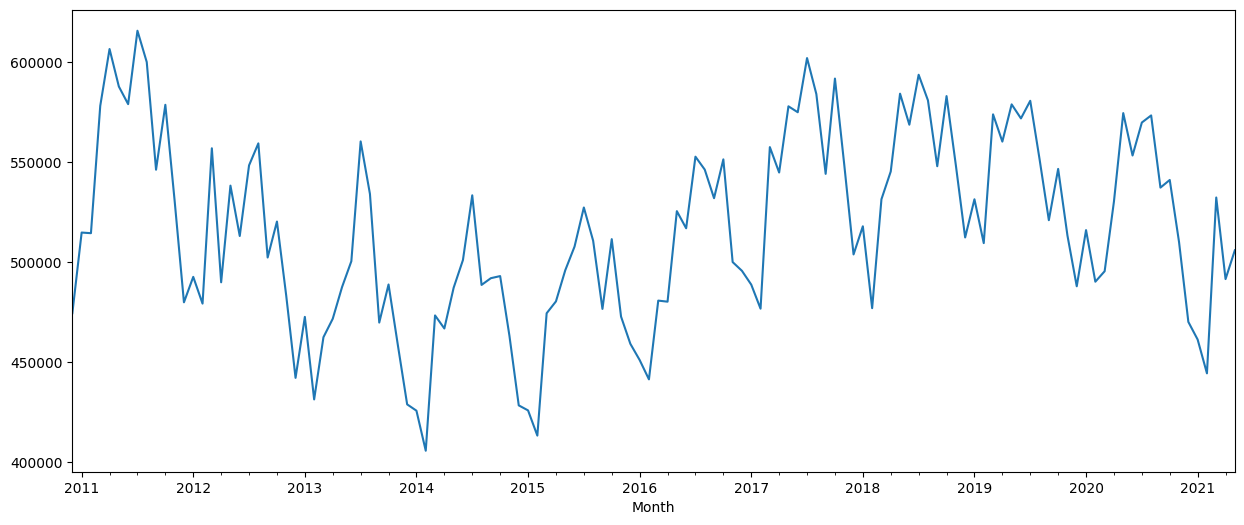

In [50]:
crimeRate_avg = crimeRate['count'].resample('MS').mean()
crimeRate_avg.plot(figsize = (15, 6))
plt.show()

<Figure size 2000x2000 with 0 Axes>

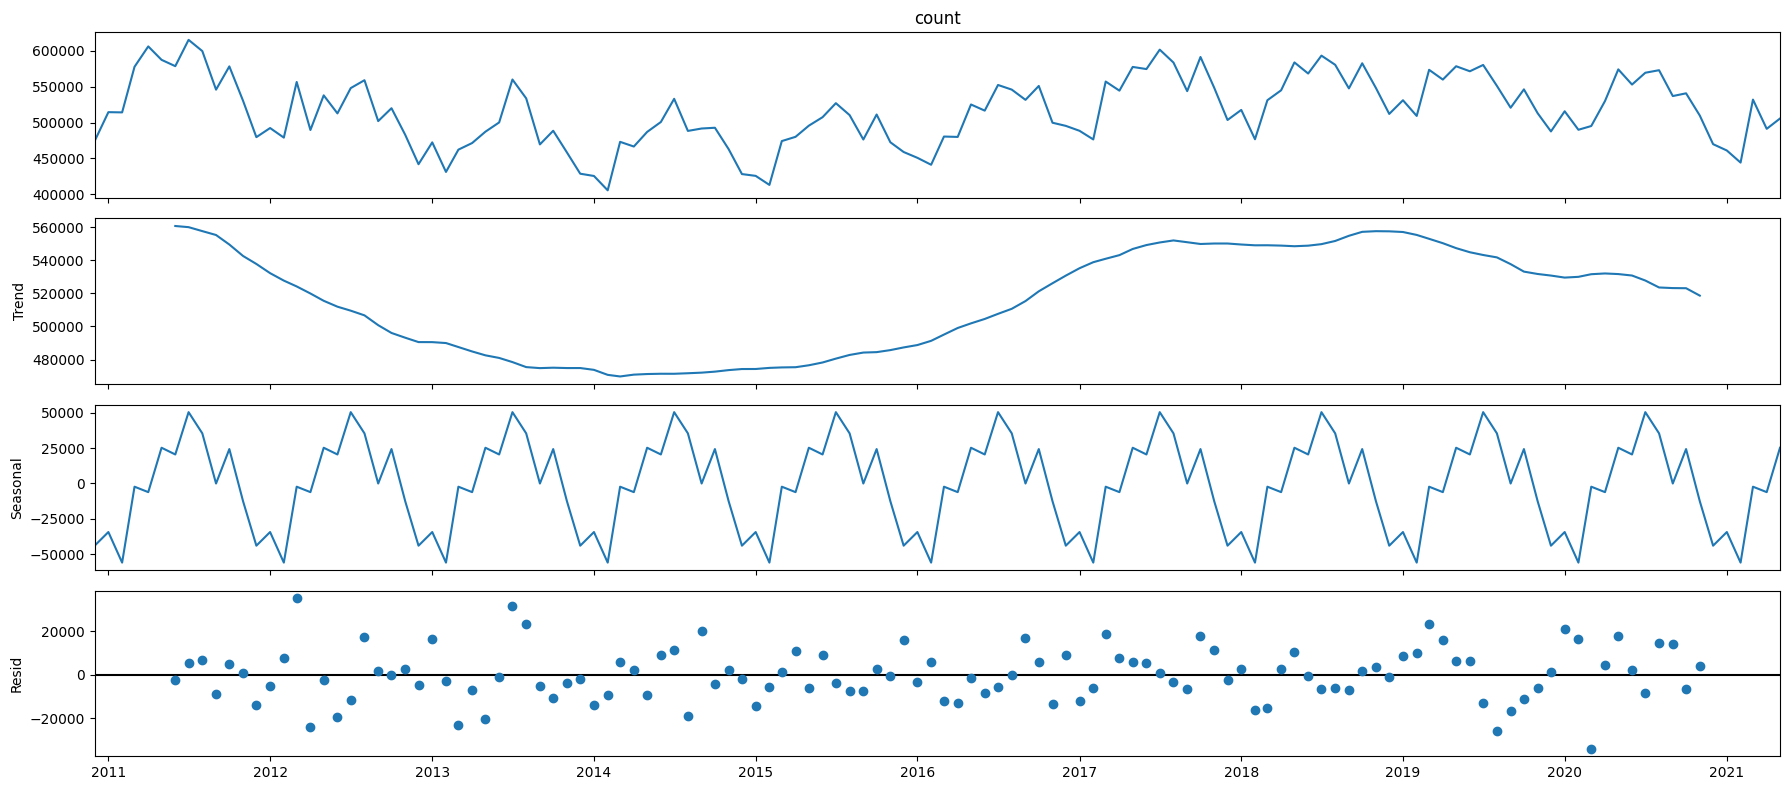

In [51]:
plt.figure(figsize=(20,20))
decomposition = sm.tsa.seasonal_decompose(crimeRate_avg, model='additive')
fig = decomposition.plot()
plt.show()

In [52]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(crimeRate_avg))

Results of Dickey-Fuller Test:
Test Statistic                  -1.621719
p-value                          0.471828
#Lags Used                      12.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64
None


Results of Dickey-Fuller Test:
Test Statistic                  -2.164937
p-value                          0.219216
#Lags Used                      13.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64
None


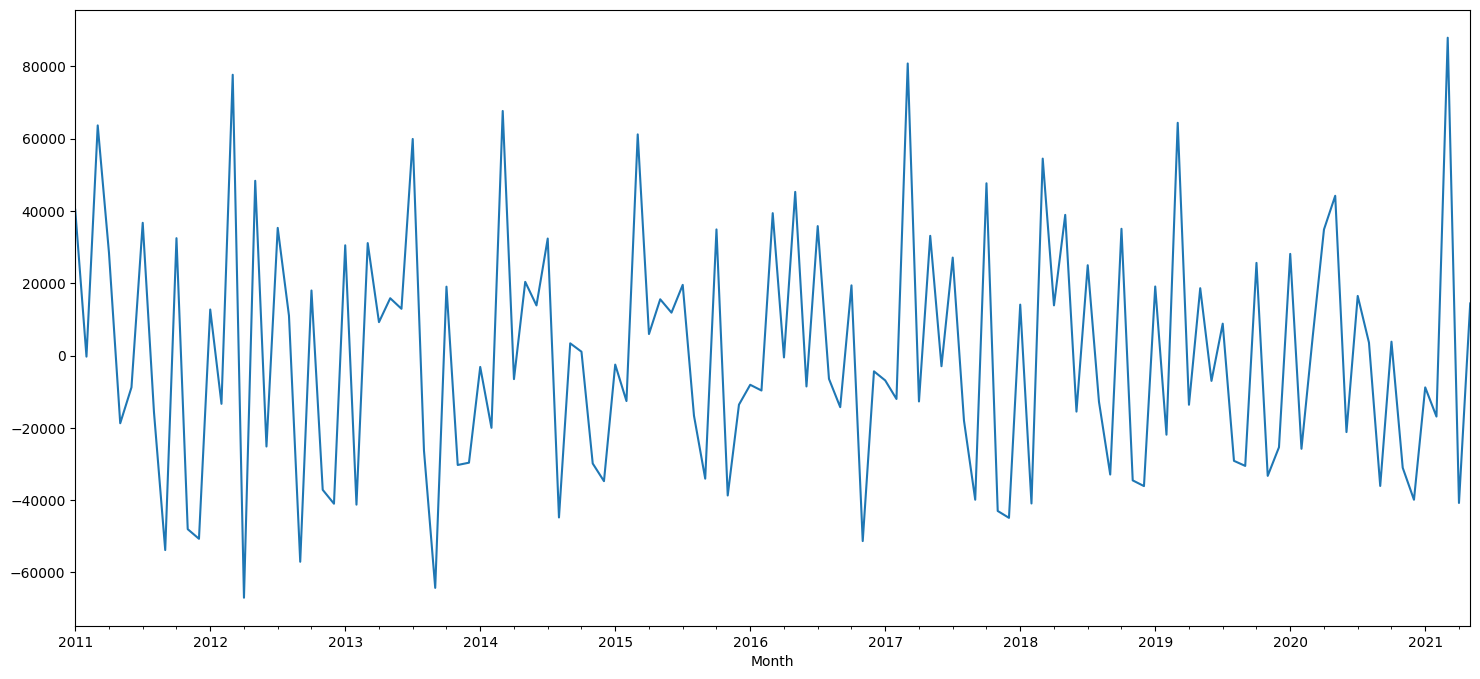

In [53]:
# differenceing

ts_t_adj = crimeRate_avg - crimeRate_avg.shift(1)
ts_t_adj = ts_t_adj.dropna()
ts_t_adj.plot()

print(adf_test(ts_t_adj))

Results of Dickey-Fuller Test:
Test Statistic                  -2.164937
p-value                          0.219216
#Lags Used                      13.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64
None


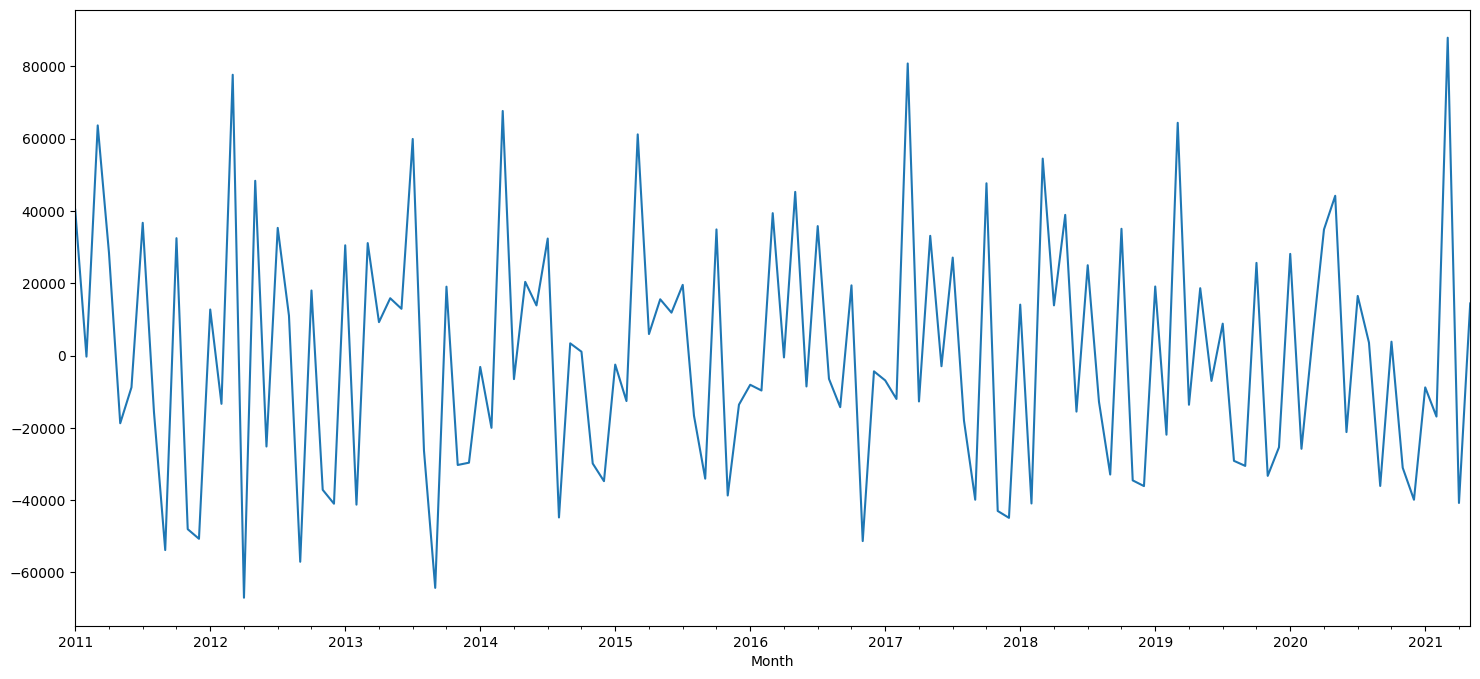

In [54]:
# differenceing

ts_s_adj = crimeRate_avg - crimeRate_avg.shift(12)
ts_s_adj = ts_t_adj.dropna()
ts_s_adj.plot()

print(adf_test(ts_s_adj))

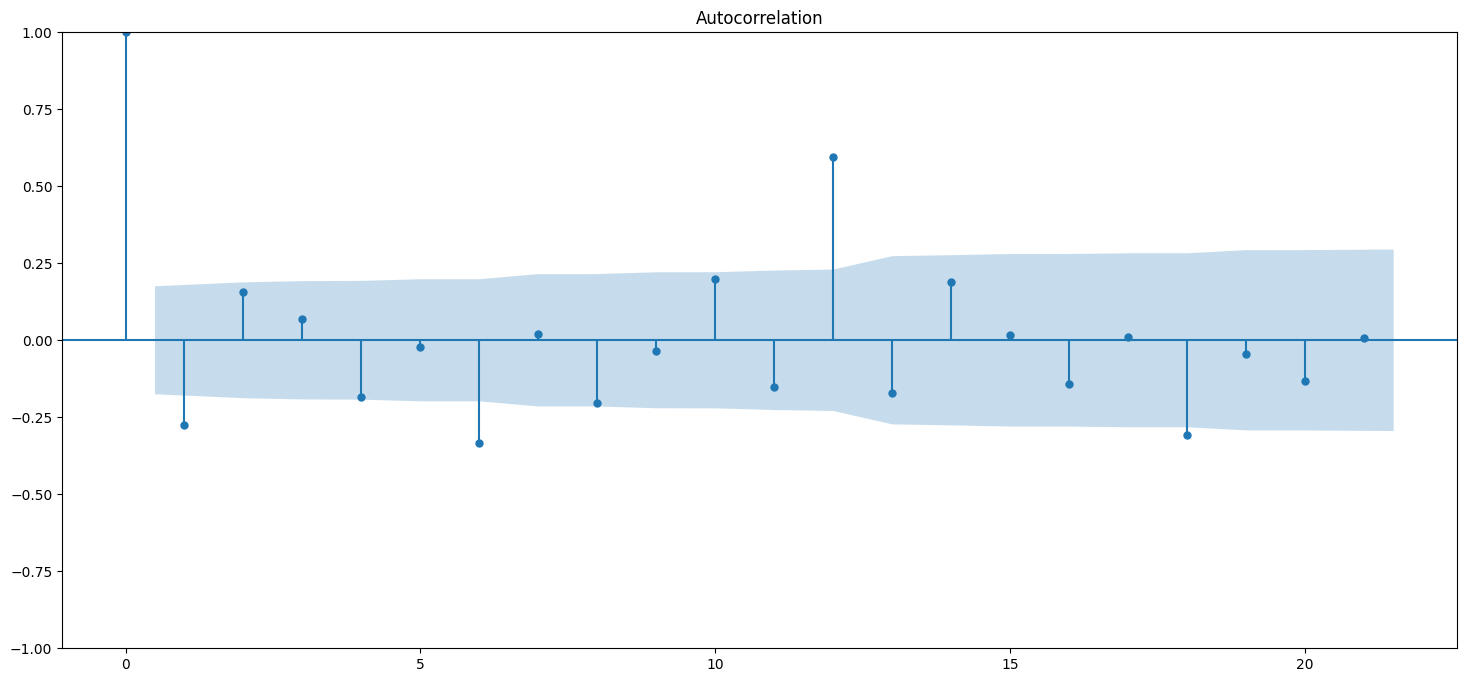

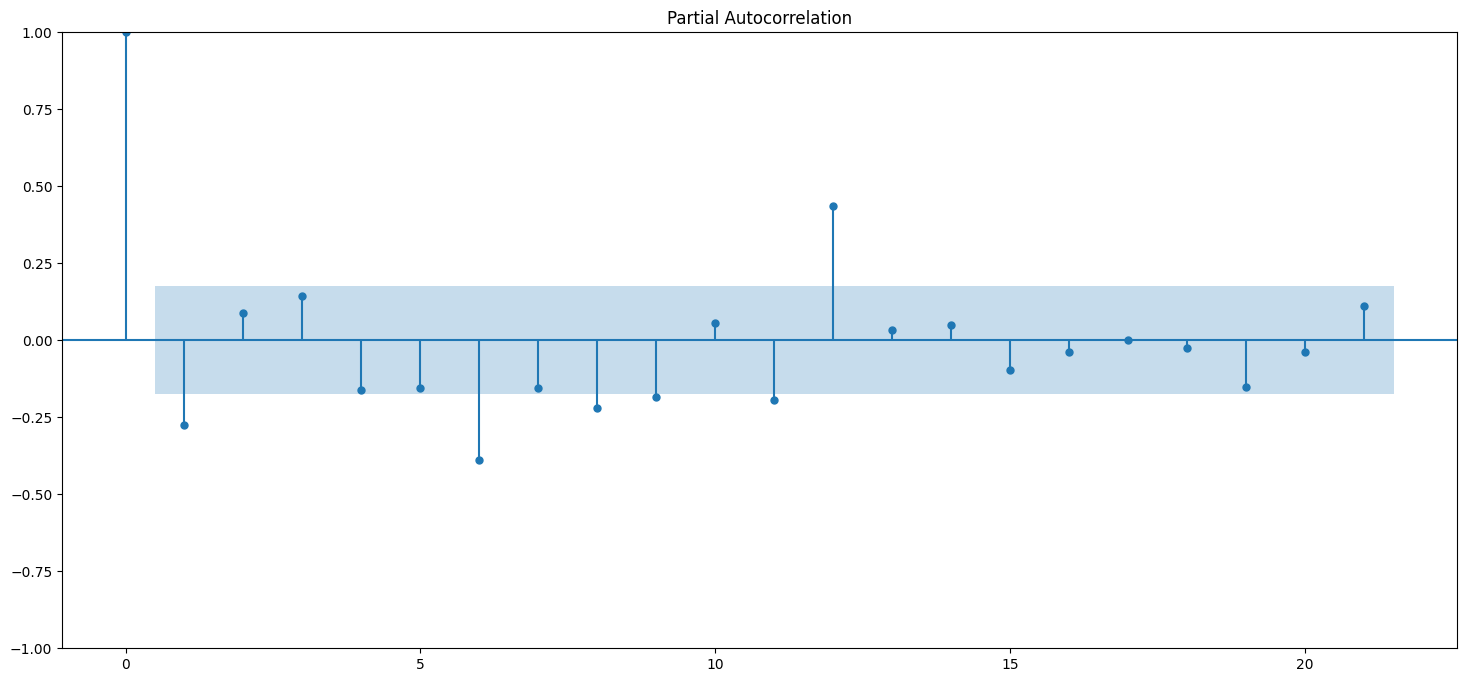

In [55]:
plot_acf(ts_s_adj)
matplotlib.pyplot.show()
plot_pacf(ts_s_adj)
matplotlib.pyplot.show()

In [56]:
# using the model params obtained from previous cell and fitting the model
mod = sm.tsa.statespace.SARIMAX(crimeRate_avg,
                                            order=(2,2,0),
                                            seasonal_order=(0,2,2,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()

In [57]:
print(results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   count   No. Observations:                  126
Model:             SARIMAX(2, 2, 0)x(0, 2, [1, 2], 12)   Log Likelihood                -889.881
Date:                                 Fri, 17 Jan 2025   AIC                           1789.761
Time:                                         05:08:54   BIC                           1801.349
Sample:                                     12-01-2010   HQIC                          1794.388
                                          - 05-01-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7658      0.339     -2.259      0.024      -1.430      -0

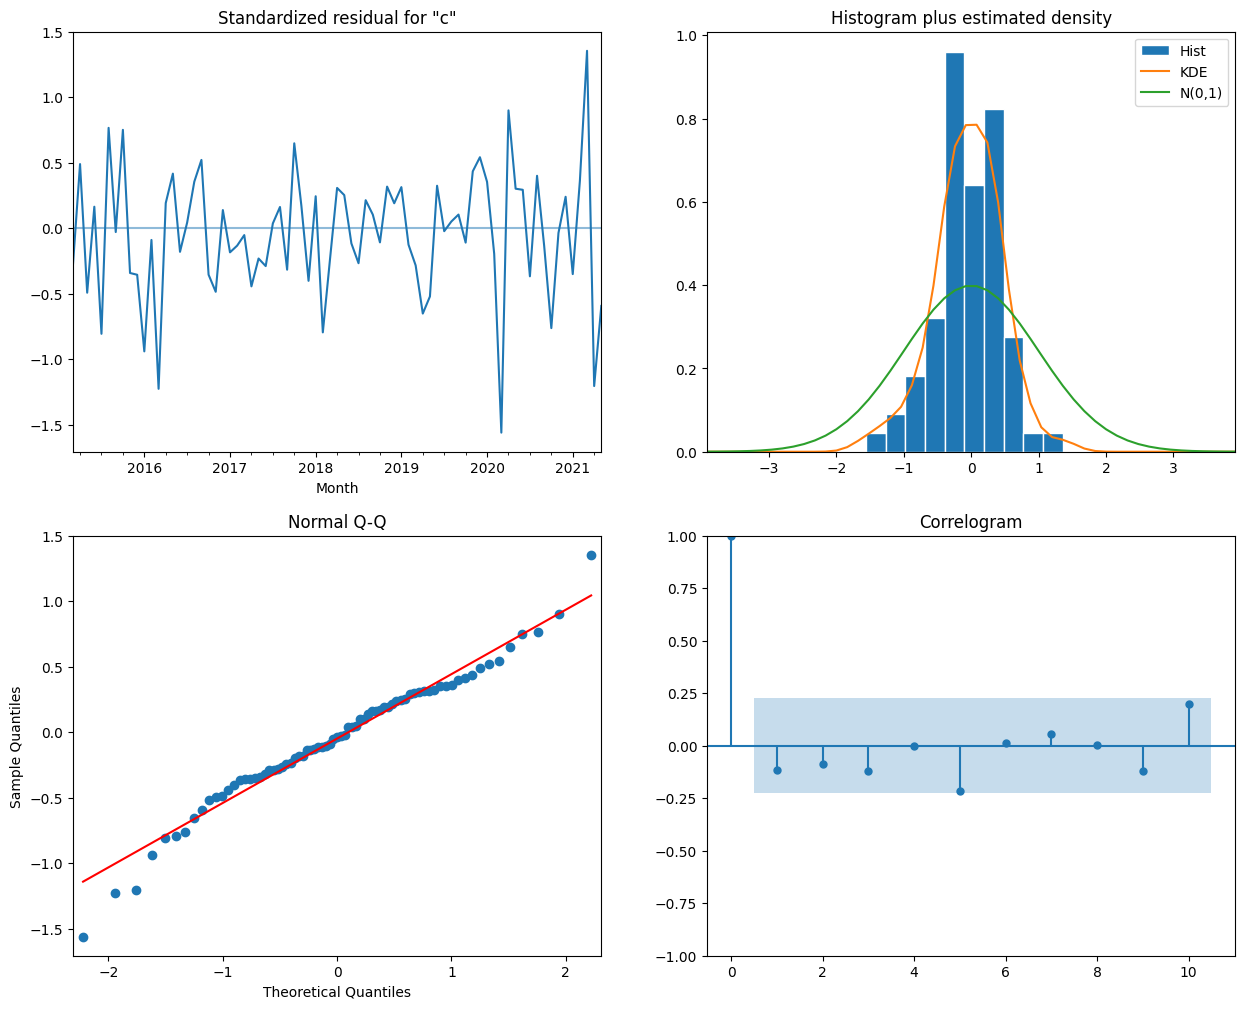

In [58]:
results.plot_diagnostics(figsize=(15,12));

In [59]:
crimeRate['arima_model'] = results.fittedvalues
crimeRate['arima_model'][:12+1] = np.NaN
forecast = results.predict(start=crimeRate.shape[0], end=crimeRate.shape[0] + 12)

<ipython-input-59-5cfec26fb814>:2: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-59-5cfec26fb814>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

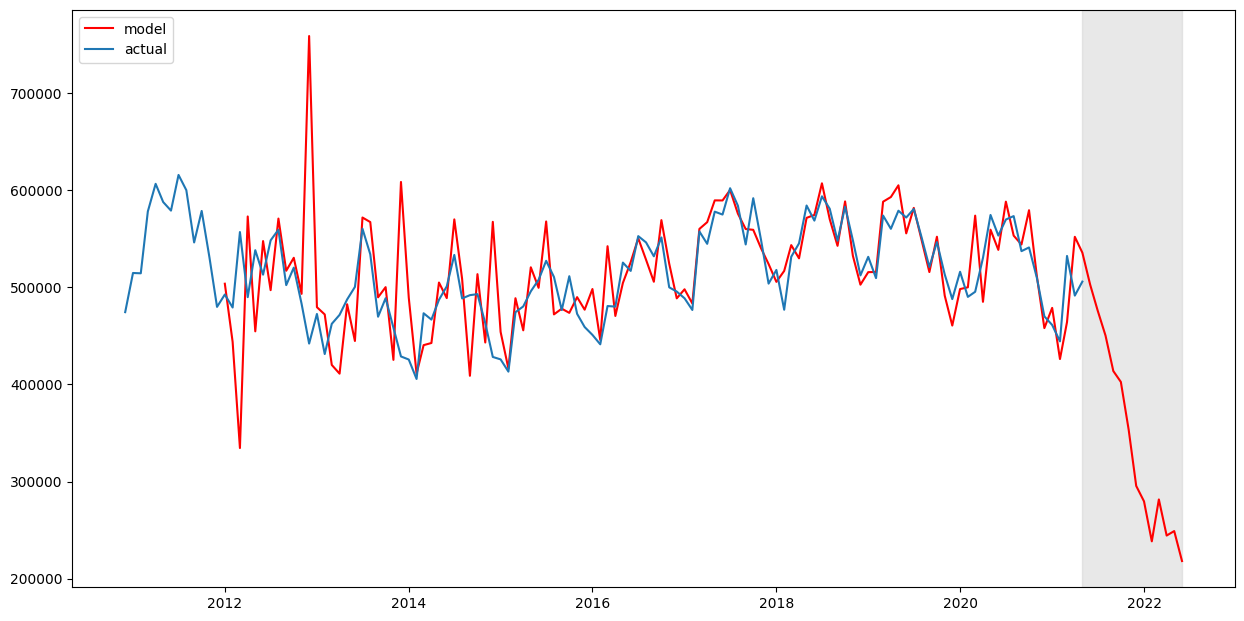

In [60]:
forecast = pd.concat([crimeRate['arima_model'], forecast])
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(crimeRate.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(crimeRate['count'], label='actual')
plt.legend()
plt.show()


In [ ]:
!jupyter nbconvert --to html --execute your_notebook_name.ipynb

In [ ]:
#!pip install pmdarima